---
**Dataset:** Amazon Product Reviews (`amazon_reviews.csv`)  
**Task:** Binary Sentiment Classification (Positive/Negative)  
**Model:** Recurrent Neural Network (RNN)  
**Evaluation Metrics:** Accuracy, Precision, Recall, F1-Score  

---

# E-Commerce Product Review Sentiment Classification using RNN

In this notebook, we will build a Recurrent Neural Network (RNN) to classify e-commerce product reviews as **Positive** or **Negative**. RNNs are designed to handle sequential data, making them ideal for text processing where word order matters.

**Project Steps:**
1. Import necessary libraries
2. Load and explore the dataset
3. Preprocess text (tokenization, padding, vocabulary building)
4. Split data into train/test sets
5. Create the RNN model architecture
6. Train the model
7. Evaluate performance
8. Test on sample reviews

## Step 1: Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


## Step 2: Load and Explore the Dataset

We'll load the Amazon product reviews dataset. The dataset contains reviews with ratings (1-5 stars). 
We'll convert this to binary sentiment: ratings 4-5 are Positive (1), ratings 1-3 are Negative (0).

In [2]:
# Load the Amazon reviews dataset
df = pd.read_csv('amazon_reviews.csv')

print(f"Total reviews in dataset: {len(df)}")
print(f"\nDataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

# Check for missing values in key columns
print(f"\nMissing values:")
print(f"  reviewText: {df['reviewText'].isna().sum()}")
print(f"  overall: {df['overall'].isna().sum()}")

# Remove rows with missing review text
df = df.dropna(subset=['reviewText', 'overall'])
print(f"\nDataset after removing missing values: {len(df)} reviews")

# Convert ratings to binary sentiment
# Ratings 4-5: Positive (1), Ratings 1-3: Negative (0)
df['sentiment'] = (df['overall'] >= 4.0).astype(int)

print(f"\nRating distribution:")
print(df['overall'].value_counts().sort_index())
print(f"\nSentiment distribution:")
print(df['sentiment'].value_counts())
print(f"  Positive (1): {(df['sentiment'] == 1).sum()} ({(df['sentiment'] == 1).sum() / len(df) * 100:.1f}%)")
print(f"  Negative (0): {(df['sentiment'] == 0).sum()} ({(df['sentiment'] == 0).sum() / len(df) * 100:.1f}%)")

# Sample some reviews
print(f"\n{'='*80}")
print("Sample Positive Reviews:")
print('='*80)
for i, row in df[df['sentiment'] == 1].head(3).iterrows():
    print(f"Rating: {row['overall']} | Review: {row['reviewText'][:100]}...")
    
print(f"\n{'='*80}")
print("Sample Negative Reviews:")
print('='*80)
for i, row in df[df['sentiment'] == 0].head(3).iterrows():
    print(f"Rating: {row['overall']} | Review: {row['reviewText'][:100]}...")

Total reviews in dataset: 4915

Dataset shape: (4915, 12)

Column names: ['Unnamed: 0', 'reviewerName', 'overall', 'reviewText', 'reviewTime', 'day_diff', 'helpful_yes', 'helpful_no', 'total_vote', 'score_pos_neg_diff', 'score_average_rating', 'wilson_lower_bound']

First few rows:
   Unnamed: 0  reviewerName  overall  \
0           0           NaN      4.0   
1           1          0mie      5.0   
2           2           1K3      4.0   
3           3           1m2      5.0   
4           4  2&amp;1/2Men      5.0   

                                          reviewText  reviewTime  day_diff  \
0                                         No issues.  2014-07-23       138   
1  Purchased this for my device, it worked as adv...  2013-10-25       409   
2  it works as expected. I should have sprung for...  2012-12-23       715   
3  This think has worked out great.Had a diff. br...  2013-11-21       382   
4  Bought it with Retail Packaging, arrived legit...  2013-07-13       513   

   help

## Step 3: Text Preprocessing

We need to:
1. Clean the text (remove special characters, lowercase)
2. Tokenize the reviews (convert words to tokens)
3. Build a vocabulary (map words to unique indices)
4. Convert text to sequences of indices
5. Pad sequences to a fixed length

In [3]:
def clean_text(text):
    """Clean and normalize text"""
    # Convert to string (in case of non-string values)
    text = str(text)
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits, keep only letters and spaces
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = ' '.join(text.split())
    return text

# Clean all reviews
df['cleaned_review'] = df['reviewText'].apply(clean_text)

# Remove empty reviews after cleaning
df = df[df['cleaned_review'].str.len() > 0]

print(f"Dataset after cleaning: {len(df)} reviews")
print("\nSample cleaned reviews:")
for i in range(3):
    print(f"\nOriginal: {df['reviewText'].iloc[i][:80]}...")
    print(f"Cleaned:  {df['cleaned_review'].iloc[i][:80]}...")

Dataset after cleaning: 4914 reviews

Sample cleaned reviews:

Original: No issues....
Cleaned:  no issues...

Original: Purchased this for my device, it worked as advertised. You can never have too mu...
Cleaned:  purchased this for my device it worked as advertised you can never have too much...

Original: it works as expected. I should have sprung for the higher capacity.  I think its...
Cleaned:  it works as expected i should have sprung for the higher capacity i think its ma...


In [4]:
# Tokenize and build vocabulary
def tokenize(text):
    """Split text into words"""
    return text.split()

# Tokenize all reviews
df['tokens'] = df['cleaned_review'].apply(tokenize)

# Build vocabulary from all tokens
all_words = []
for tokens in df['tokens']:
    all_words.extend(tokens)

# Count word frequencies
word_counts = Counter(all_words)
print(f"Total words: {len(all_words)}")
print(f"Total unique words: {len(word_counts)}")

# Filter vocabulary: keep words that appear at least 2 times
min_word_freq = 2
filtered_word_counts = {word: count for word, count in word_counts.items() if count >= min_word_freq}

print(f"Vocabulary size after filtering (min_freq={min_word_freq}): {len(filtered_word_counts)}")
print(f"\nMost common words:")
for word, count in Counter(filtered_word_counts).most_common(20):
    print(f"  {word}: {count}")

# Create word-to-index mapping (reserve 0 for padding, 1 for unknown words)
vocab = {'<PAD>': 0, '<UNK>': 1}
for word in filtered_word_counts.keys():
    vocab[word] = len(vocab)

vocab_size = len(vocab)
print(f"\nFinal vocabulary size (including <PAD> and <UNK>): {vocab_size}")

Total words: 243009
Total unique words: 9826
Vocabulary size after filtering (min_freq=2): 4215

Most common words:
  the: 9084
  i: 8122
  and: 7586
  it: 6838
  to: 6139
  a: 5589
  my: 5057
  card: 4603
  this: 4494
  for: 4035
  in: 3377
  of: 3369
  is: 3111
  with: 3057
  on: 2221
  have: 2153
  that: 1933
  gb: 1725
  phone: 1685
  was: 1644

Final vocabulary size (including <PAD> and <UNK>): 4217


In [5]:
# Convert tokens to sequences of indices
def tokens_to_sequence(tokens, vocab):
    """Convert list of tokens to list of indices"""
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]

df['sequence'] = df['tokens'].apply(lambda x: tokens_to_sequence(x, vocab))

# Analyze sequence lengths
sequence_lengths = [len(seq) for seq in df['sequence']]
print(f"Sequence length statistics:")
print(f"  Min: {min(sequence_lengths)}")
print(f"  Max: {max(sequence_lengths)}")
print(f"  Mean: {np.mean(sequence_lengths):.1f}")
print(f"  Median: {np.median(sequence_lengths):.1f}")
print(f"  90th percentile: {np.percentile(sequence_lengths, 90):.1f}")
print(f"  95th percentile: {np.percentile(sequence_lengths, 95):.1f}")

# Set a fixed sequence length (truncate long reviews, pad short ones)
# Using 95th percentile as a good balance
sequence_length = int(np.percentile(sequence_lengths, 95))
print(f"\nSetting fixed sequence length to: {sequence_length}")

# Pad sequences to fixed length
def pad_sequence(sequence, max_len, pad_value=0):
    """Pad or truncate sequence to max_len"""
    if len(sequence) >= max_len:
        return sequence[:max_len]
    else:
        return sequence + [pad_value] * (max_len - len(sequence))

df['padded_sequence'] = df['sequence'].apply(lambda x: pad_sequence(x, sequence_length))

print(f"\nAll sequences padded to length: {sequence_length}")
print(f"\nSample padded sequences:")
for i in range(2):
    print(f"\nReview: {df['reviewText'].iloc[i][:60]}...")
    print(f"Sentiment: {df['sentiment'].iloc[i]}")
    print(f"Sequence length: {len(df['sequence'].iloc[i])}")
    print(f"Padded sequence (first 20): {df['padded_sequence'].iloc[i][:20]}")

Sequence length statistics:
  Min: 1
  Max: 1515
  Mean: 49.5
  Median: 32.0
  90th percentile: 96.0
  95th percentile: 131.0

Setting fixed sequence length to: 131

All sequences padded to length: 131

Sample padded sequences:

Review: No issues....
Sentiment: 1
Sequence length: 2
Padded sequence (first 20): [2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Review: Purchased this for my device, it worked as advertised. You c...
Sentiment: 1
Sequence length: 31
Padded sequence (first 20): [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


## Step 4: Train/Test Split

Split the data into training and testing sets (80% train, 20% test)

In [6]:
# Prepare X and y
X = np.array(df['padded_sequence'].tolist())
y = np.array(df['sentiment'].values)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"\nTraining sentiment distribution:")
print(f"  Positive: {np.sum(y_train == 1)} ({np.sum(y_train == 1) / len(y_train) * 100:.1f}%)")
print(f"  Negative: {np.sum(y_train == 0)} ({np.sum(y_train == 0) / len(y_train) * 100:.1f}%)")
print(f"\nTesting sentiment distribution:")
print(f"  Positive: {np.sum(y_test == 1)} ({np.sum(y_test == 1) / len(y_test) * 100:.1f}%)")
print(f"  Negative: {np.sum(y_test == 0)} ({np.sum(y_test == 0) / len(y_test) * 100:.1f}%)")

X shape: (4914, 131)
y shape: (4914,)

Training set: 3931 samples
Testing set: 983 samples

Training sentiment distribution:
  Positive: 3558 (90.5%)
  Negative: 373 (9.5%)

Testing sentiment distribution:
  Positive: 890 (90.5%)
  Negative: 93 (9.5%)


## Step 5: Create PyTorch DataLoaders

Convert numpy arrays to PyTorch tensors and create DataLoader objects for batch processing

In [7]:
# Convert to PyTorch tensors
X_train_tensor = torch.LongTensor(X_train)
X_test_tensor = torch.LongTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train)
y_test_tensor = torch.FloatTensor(y_test)

print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32  # Larger batch size for larger dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nBatch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of testing batches: {len(test_loader)}")

X_train_tensor shape: torch.Size([3931, 131])
y_train_tensor shape: torch.Size([3931])

Batch size: 32
Number of training batches: 123
Number of testing batches: 31


## Step 6: Build the RNN Model

We'll create an RNN model with:
- **Embedding layer**: Converts word indices to dense vectors
- **RNN layer**: Processes the sequential data
- **Fully connected layer**: Outputs the sentiment prediction (0 or 1)

In [8]:
class SentimentRNN(nn.Module):
    """
    RNN model for sentiment classification
    
    Architecture:
    1. Embedding layer: Converts word indices to dense vectors
    2. RNN layer: Processes sequential data with recurrent connections
    3. Fully connected layer: Outputs binary sentiment prediction
    """
    def __init__(self, vocab_size, embedding_dim=128, hidden_size=128, num_layers=2, dropout=0.3):
        super(SentimentRNN, self).__init__()
        
        # Embedding layer: maps word indices to dense vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # RNN layer with dropout for regularization
        self.rnn = nn.RNN(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            nonlinearity='tanh'
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, 1)
        
        # Sigmoid activation for binary classification
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        """
        Forward pass through the network
        
        Args:
            x: Input tensor of shape (batch_size, sequence_length)
        
        Returns:
            predictions: Tensor of shape (batch_size, 1) with values between 0 and 1
        """
        # Embedding: (batch_size, seq_len) -> (batch_size, seq_len, embedding_dim)
        embedded = self.embedding(x)
        
        # RNN: returns output for all time steps and final hidden state
        # out shape: (batch_size, seq_len, hidden_size)
        out, hidden = self.rnn(embedded)
        
        # Take the output from the last time step
        # last_output shape: (batch_size, hidden_size)
        last_output = out[:, -1, :]
        
        # Apply dropout
        last_output = self.dropout(last_output)
        
        # Fully connected layer
        # fc_out shape: (batch_size, 1)
        fc_out = self.fc(last_output)
        
        # Sigmoid activation for binary classification
        predictions = self.sigmoid(fc_out)
        
        return predictions.squeeze()

# Create model instance
model = SentimentRNN(
    vocab_size=vocab_size,
    embedding_dim=128,
    hidden_size=128,
    num_layers=2,
    dropout=0.3
).to(device)

print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Model Architecture:
SentimentRNN(
  (embedding): Embedding(4217, 128, padding_idx=0)
  (rnn): RNN(128, 128, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 605,953


## Step 7: Train the Model

We'll train the model using Binary Cross-Entropy loss and the Adam optimizer.

In [9]:
# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Loss function: Binary Cross-Entropy")
print("Optimizer: Adam (lr=0.001)")

Loss function: Binary Cross-Entropy
Optimizer: Adam (lr=0.001)


In [10]:
# Training loop
EPOCHS = 10

# Track losses and accuracies
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

print("Starting training...\n")

for epoch in range(1, EPOCHS + 1):
    # ========== Training Phase ==========
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for batch_idx, (xb, yb) in enumerate(train_loader):
        xb, yb = xb.to(device), yb.to(device)
        
        # Forward pass
        predictions = model(xb)
        loss = criterion(predictions, yb)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track loss and accuracy
        train_loss += loss.item() * xb.size(0)
        predicted_labels = (predictions >= 0.5).float()
        train_correct += (predicted_labels == yb).sum().item()
        train_total += yb.size(0)
    
    # Calculate average training loss and accuracy
    avg_train_loss = train_loss / train_total
    train_accuracy = train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    # ========== Testing Phase ==========
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            
            # Forward pass
            predictions = model(xb)
            loss = criterion(predictions, yb)
            
            # Track loss and accuracy
            test_loss += loss.item() * xb.size(0)
            predicted_labels = (predictions >= 0.5).float()
            test_correct += (predicted_labels == yb).sum().item()
            test_total += yb.size(0)
    
    # Calculate average testing loss and accuracy
    avg_test_loss = test_loss / test_total
    test_accuracy = test_correct / test_total
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)
    
    # Print epoch results
    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
          f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_accuracy:.4f}")

print("\nTraining completed!")

Starting training...

Epoch 01/10 | Train Loss: 0.3298 | Train Acc: 0.8982 | Test Loss: 0.3006 | Test Acc: 0.9054
Epoch 01/10 | Train Loss: 0.3298 | Train Acc: 0.8982 | Test Loss: 0.3006 | Test Acc: 0.9054
Epoch 02/10 | Train Loss: 0.2995 | Train Acc: 0.9089 | Test Loss: 0.3089 | Test Acc: 0.9095
Epoch 02/10 | Train Loss: 0.2995 | Train Acc: 0.9089 | Test Loss: 0.3089 | Test Acc: 0.9095
Epoch 03/10 | Train Loss: 0.2858 | Train Acc: 0.9194 | Test Loss: 0.2892 | Test Acc: 0.9064
Epoch 03/10 | Train Loss: 0.2858 | Train Acc: 0.9194 | Test Loss: 0.2892 | Test Acc: 0.9064
Epoch 04/10 | Train Loss: 0.2815 | Train Acc: 0.9206 | Test Loss: 0.2908 | Test Acc: 0.9084
Epoch 04/10 | Train Loss: 0.2815 | Train Acc: 0.9206 | Test Loss: 0.2908 | Test Acc: 0.9084
Epoch 05/10 | Train Loss: 0.2779 | Train Acc: 0.9219 | Test Loss: 0.2916 | Test Acc: 0.9084
Epoch 05/10 | Train Loss: 0.2779 | Train Acc: 0.9219 | Test Loss: 0.2916 | Test Acc: 0.9084
Epoch 06/10 | Train Loss: 0.2797 | Train Acc: 0.9219 | Tes

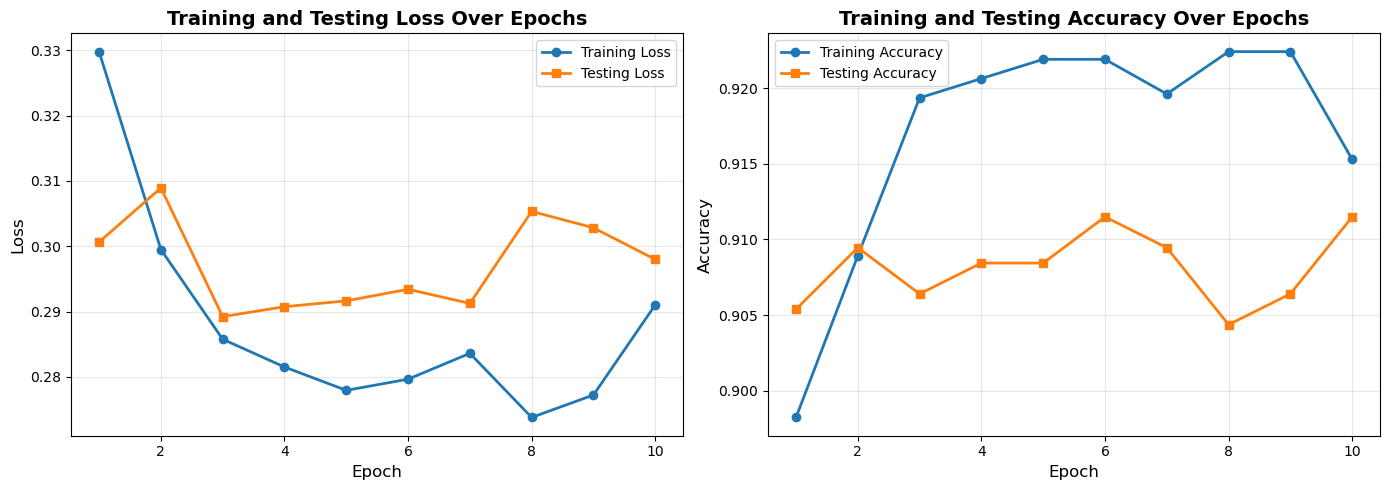


Final Results:
  Best Training Accuracy: 0.9224
  Best Testing Accuracy: 0.9115


In [11]:
# Visualize training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot losses
ax1.plot(range(1, EPOCHS + 1), train_losses, 'o-', label='Training Loss', linewidth=2)
ax1.plot(range(1, EPOCHS + 1), test_losses, 's-', label='Testing Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Testing Loss Over Epochs', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracies
ax2.plot(range(1, EPOCHS + 1), train_accuracies, 'o-', label='Training Accuracy', linewidth=2)
ax2.plot(range(1, EPOCHS + 1), test_accuracies, 's-', label='Testing Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training and Testing Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Results:")
print(f"  Best Training Accuracy: {max(train_accuracies):.4f}")
print(f"  Best Testing Accuracy: {max(test_accuracies):.4f}")

## Step 8: Evaluate Model Performance

Calculate comprehensive metrics: Accuracy, Precision, Recall, and F1-Score

In [12]:
# Get predictions on test set
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        predictions = model(xb)
        predicted_labels = (predictions >= 0.5).float()
        
        all_predictions.extend(predicted_labels.cpu().numpy())
        all_labels.extend(yb.numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

print("="*60)
print("MODEL EVALUATION METRICS")
print("="*60)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
print("="*60)

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_predictions, 
                          target_names=['Negative', 'Positive'],
                          digits=4))

MODEL EVALUATION METRICS
Accuracy:  0.9115 (91.15%)
Precision: 0.9135 (91.35%)
Recall:    0.9966 (99.66%)
F1-Score:  0.9533 (95.33%)

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative     0.7500    0.0968    0.1714        93
    Positive     0.9135    0.9966    0.9533       890

    accuracy                         0.9115       983
   macro avg     0.8317    0.5467    0.5623       983
weighted avg     0.8980    0.9115    0.8793       983



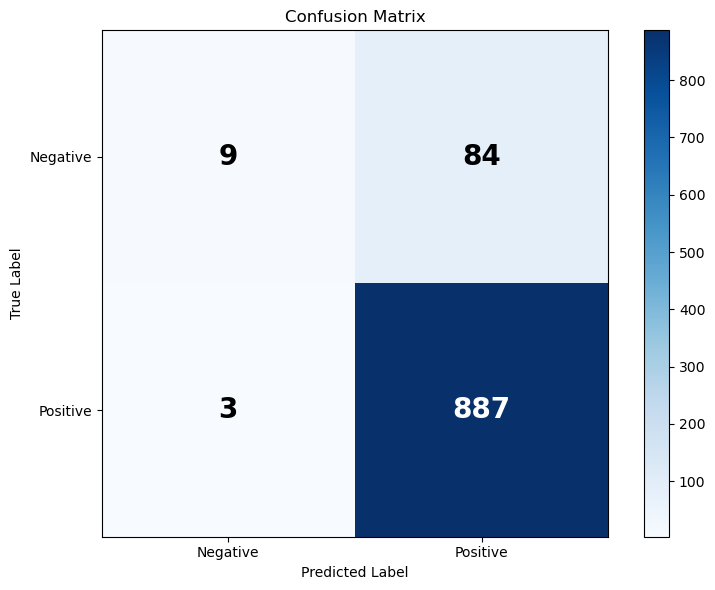

Confusion Matrix Interpretation:
  True Negatives (TN):  9 - Correctly predicted negative reviews
  False Positives (FP): 84 - Incorrectly predicted as positive
  False Negatives (FN): 3 - Incorrectly predicted as negative
  True Positives (TP):  887 - Correctly predicted positive reviews


In [13]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Labels
classes = ['Negative', 'Positive']
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       ylabel='True Label',
       xlabel='Predicted Label',
       title='Confusion Matrix')

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=20, fontweight='bold')

plt.tight_layout()
plt.show()

print("Confusion Matrix Interpretation:")
print(f"  True Negatives (TN):  {cm[0, 0]} - Correctly predicted negative reviews")
print(f"  False Positives (FP): {cm[0, 1]} - Incorrectly predicted as positive")
print(f"  False Negatives (FN): {cm[1, 0]} - Incorrectly predicted as negative")
print(f"  True Positives (TP):  {cm[1, 1]} - Correctly predicted positive reviews")

## Step 9: Make Predictions on New Reviews

Test the model on sample reviews with confidence scores

In [14]:
def predict_sentiment(review_text, model, vocab, sequence_length, device):
    """
    Predict sentiment for a single review
    
    Args:
        review_text: String containing the review
        model: Trained RNN model
        vocab: Word-to-index vocabulary
        sequence_length: Fixed length for padding
        device: Device to run inference on
    
    Returns:
        sentiment: 'Positive' or 'Negative'
        confidence: Confidence score (0-1)
        rating: Estimated rating (1-5 based on confidence)
    """
    model.eval()
    
    # Preprocess the review
    cleaned = clean_text(review_text)
    tokens = tokenize(cleaned)
    sequence = tokens_to_sequence(tokens, vocab)
    padded = pad_sequence(sequence, sequence_length)
    
    # Convert to tensor
    input_tensor = torch.LongTensor([padded]).to(device)
    
    # Get prediction
    with torch.no_grad():
        output = model(input_tensor)
        confidence = output.item()
    
    # Determine sentiment
    sentiment = "Positive" if confidence >= 0.5 else "Negative"
    
    # Estimate rating (1-5 scale)
    # Map confidence [0, 1] to rating scale
    if sentiment == "Positive":
        # Confidence 0.5-1.0 maps to ratings 4-5
        rating = 4 + (confidence - 0.5) * 2
    else:
        # Confidence 0.0-0.5 maps to ratings 1-3
        rating = 1 + confidence * 4
    
    return sentiment, confidence, rating

# Test on sample reviews from the test set
print("="*80)
print("PREDICTIONS ON TEST SET SAMPLES")
print("="*80)

sample_indices = np.random.choice(len(X_test), 5, replace=False)

for idx in sample_indices:
    original_idx = df.index[len(X_train) + idx]
    review_text = df.loc[original_idx, 'reviewText']
    true_sentiment = "Positive" if df.loc[original_idx, 'sentiment'] == 1 else "Negative"
    true_rating = df.loc[original_idx, 'overall']
    
    pred_sentiment, confidence, pred_rating = predict_sentiment(
        review_text, model, vocab, sequence_length, device
    )
    
    print(f"\nReview: {review_text[:100]}...")
    print(f"True Sentiment: {true_sentiment} (Rating: {true_rating})")
    print(f"Predicted: {pred_sentiment} | Confidence: {confidence:.4f} | Est. Rating: {pred_rating:.2f}")
    print("-"*80)

PREDICTIONS ON TEST SET SAMPLES

Review: I have tried to copy out the files and it is an astonishingly 40MB/s  Not sure why others are gettin...
True Sentiment: Positive (Rating: 5.0)
Predicted: Positive | Confidence: 0.9277 | Est. Rating: 4.86
--------------------------------------------------------------------------------

Review: Product arrived on time as expected and worked exactly as advertised. A good buy on a product that w...
True Sentiment: Positive (Rating: 5.0)
Predicted: Positive | Confidence: 0.8668 | Est. Rating: 4.73
--------------------------------------------------------------------------------

Review: It writes according to SanDisk app test only with the speed of 16mb/second. I have expected a little...
True Sentiment: Negative (Rating: 3.0)
Predicted: Positive | Confidence: 0.9234 | Est. Rating: 4.85
--------------------------------------------------------------------------------

Review: I added this SanDisk Ultra 32 GB microSDHC to my smartphone, and it works per

In [15]:
# Test on custom reviews (new unseen reviews)
print("\n" + "="*80)
print("PREDICTIONS ON NEW CUSTOM REVIEWS")
print("="*80)

custom_reviews = [
    "This product is absolutely amazing! Best purchase I've ever made. Highly recommend!",
    "Terrible quality. Broke after one day. Complete waste of money.",
    "It's okay, nothing special. Does what it's supposed to do.",
    "Love it! Exactly what I needed. Fast shipping and great quality.",
    "Do not buy this! Very disappointed with the quality and performance.",
    "Decent product for the price. Works as expected."
]

for review in custom_reviews:
    sentiment, confidence, rating = predict_sentiment(
        review, model, vocab, sequence_length, device
    )
    
    print(f"\nReview: {review}")
    print(f"Predicted: {sentiment} | Confidence: {confidence:.4f} | Est. Rating: {rating:.2f}/5.0")
    print("-"*80)


PREDICTIONS ON NEW CUSTOM REVIEWS

Review: This product is absolutely amazing! Best purchase I've ever made. Highly recommend!
Predicted: Positive | Confidence: 0.9281 | Est. Rating: 4.86/5.0
--------------------------------------------------------------------------------

Review: Terrible quality. Broke after one day. Complete waste of money.
Predicted: Positive | Confidence: 0.8820 | Est. Rating: 4.76/5.0
--------------------------------------------------------------------------------

Review: It's okay, nothing special. Does what it's supposed to do.
Predicted: Positive | Confidence: 0.9271 | Est. Rating: 4.85/5.0
--------------------------------------------------------------------------------

Review: Love it! Exactly what I needed. Fast shipping and great quality.
Predicted: Positive | Confidence: 0.9298 | Est. Rating: 4.86/5.0
--------------------------------------------------------------------------------

Review: Do not buy this! Very disappointed with the quality and performa

### Next Steps:
- Experiment with LSTM/GRU for better long-term dependencies
- Try different hyperparameters (embedding_dim, hidden_size, layers)
- Use pre-trained word embeddings (GloVe, Word2Vec)
- Implement early stopping to prevent overfitting
- Add learning rate scheduling